In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats#用于初始数据集的概率分布的拟合、统计测试、描述性统计
from sklearn.manifold import TSNE#用于数据降维，便于特征提取
from sklearn.preprocessing import OrdinalEncoder, StandardScaler#OrdinalEncoder用于数据类别编码（不是one hot），StandardScaler用于对数值特征进行标准化
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold, GridSearchCV#中面三个通过交叉验证评估模型性能，GridSearchCV用于找最佳的参数组合
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay#classification_report准确率、召回率、F1 分数和支持度等，confusion_matrix用于计算混淆矩阵的函数
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
###数据预处理
# 读取原训练集，测试集和提交文档
train = pd.read_csv(r"C:\Users\rog\Desktop\研究生\天池\信用卡欺诈kaggle\train.csv")
test = pd.read_csv(r"C:\Users\rog\Desktop\研究生\天池\信用卡欺诈kaggle\test.csv")
sample_sub=pd.read_csv(r"C:\Users\rog\Desktop\研究生\天池\信用卡欺诈kaggle\sample_submission.csv")
#打印训练集的前几行
print(train.head())
print(test.head())

   id  Time        V1        V2        V3        V4        V5        V6  \
0   0   0.0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144   
1   1   0.0  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866   
2   2   0.0  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351   
3   3   0.0  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829   
4   4   0.0  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074   

         V7        V8  ...       V21       V22       V23       V24       V25  \
0  0.110697 -0.263477  ... -0.334701 -0.887840  0.336701 -0.110835 -0.291459   
1 -1.029289  0.050198  ...  0.054848 -0.038367  0.133518 -0.461928 -0.465491   
2  0.948146 -0.084789  ... -0.326725 -0.803736  0.154495  0.951233 -0.506919   
3 -0.087826 -0.035367  ... -0.095514 -0.079792  0.167701 -0.042939  0.000799   
4 -0.938651  0.569239  ...  0.099157  0.608908  0.027901 -0.262813  0.257834   

        V26       V27       V28  Amount  Class  
0  0.207733 -0.0765

In [3]:
#shape[0]，打印训练集的总行数
print("the number of sample into the training set is {}".format(train.shape[0]))
#打印测试集的前几行

#shape[0]，打印测试集的总行数
print('The number of samples into the test set is {}.'.format(test.shape[0]))
#查看各特征的缺失值
print(train.isnull().sum())

the number of sample into the training set is 219129
The number of samples into the test set is 146087.
id        0
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [4]:
#为测试集和训练集添加两列新特征 "Day" 和 "Hour"，表示样本所处的天数和小时数，将时间戳转换为"Day"和"Hour"两列，可以更方便地对时间进行分组和分析。
seconds_per_day = 3600*24
train["Day"] = train["Time"].apply(lambda x: 1 if x<seconds_per_day else 2)
train["Hour"] = train["Time"].apply(lambda x: (x%seconds_per_day)//3600 + 1)

test["Day"] = test["Time"].apply(lambda x: 1 if x<seconds_per_day else 2)
test["Hour"] = test["Time"].apply(lambda x: (x%seconds_per_day)//3600 + 1)
train.head()
 

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V23,V24,V25,V26,V27,V28,Amount,Class,Day,Hour
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0,1,1.0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0,1,1.0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0,1,1.0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0,1,1.0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0,1,1.0


In [5]:
# 将标签为0，1的样本分割开
class_count_0, class_count_1 = train['Class'].value_counts()

class_0 = train[train['Class'] == 0]#打印出目标特征值为0的样本集
class_1 = train[train['Class'] == 1]#打印出目标特征值为1的样本集
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (218660, 34)
class 1: (469, 34)


<AxesSubplot:xlabel='Class', ylabel='count'>

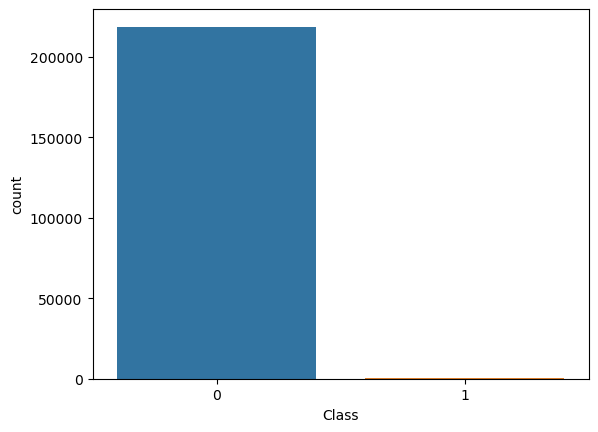

In [6]:
sns.countplot(data=train, x = 'Class')#可以看出是高度不平衡数据

Before Oversampling: 
0    218660
1       469
Name: Class, dtype: int64
After Oversampling: 
0    218660
1    218660
Name: Class, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

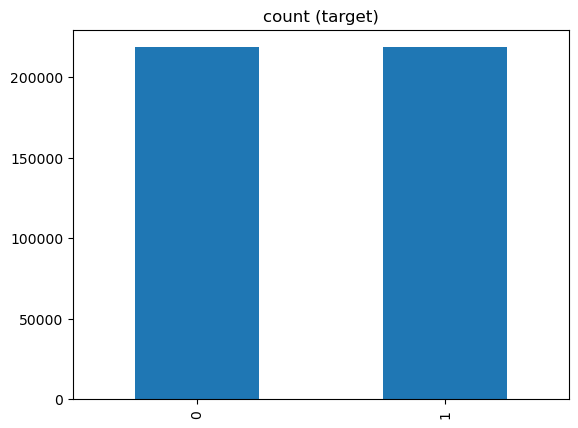

In [7]:
#用smote处理不平衡问题
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
#将特征和目标特征分开
X = train.drop('Class', axis=1)  
y = train['Class']  

smote = SMOTE(random_state=42)#随机种子数为42
X_oversampled, y_oversampled = smote.fit_resample(X, y)#将特征数据 X 和目标数据 y 传递给它进行过采样操作。
new_data = pd.concat([pd.DataFrame(X_oversampled), pd.DataFrame(y_oversampled, columns=['Class'])], axis=1)#pd.concat将特征数据帧和目标数据帧拼接

# Checking the balance
print(f"Before Oversampling: \n{y.value_counts()}")
print(f"After Oversampling: \n{y_oversampled.value_counts()}")
y_oversampled.value_counts().plot(kind='bar', title='count (target)')

In [8]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437320 entries, 0 to 437319
Data columns (total 34 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      437320 non-null  int64  
 1   Time    437320 non-null  float64
 2   V1      437320 non-null  float64
 3   V2      437320 non-null  float64
 4   V3      437320 non-null  float64
 5   V4      437320 non-null  float64
 6   V5      437320 non-null  float64
 7   V6      437320 non-null  float64
 8   V7      437320 non-null  float64
 9   V8      437320 non-null  float64
 10  V9      437320 non-null  float64
 11  V10     437320 non-null  float64
 12  V11     437320 non-null  float64
 13  V12     437320 non-null  float64
 14  V13     437320 non-null  float64
 15  V14     437320 non-null  float64
 16  V15     437320 non-null  float64
 17  V16     437320 non-null  float64
 18  V17     437320 non-null  float64
 19  V18     437320 non-null  float64
 20  V19     437320 non-null  float64
 21  V20     43

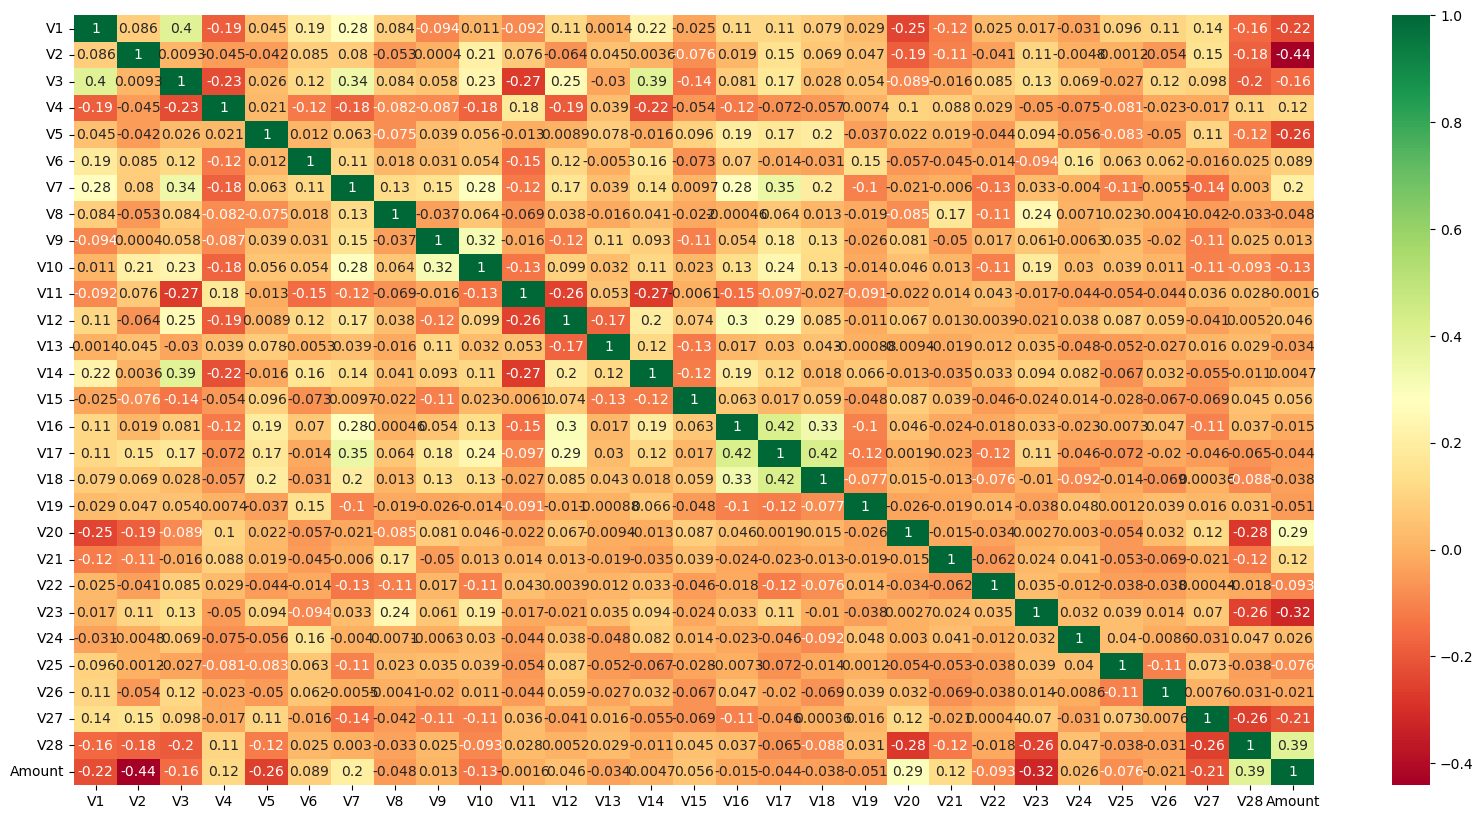

In [9]:
#用热力图表示各特征之间的相关性。可以用主成分分析对特征进行降维，逐步回归可以帮助识别最优的特征子集， 岭回归通过在损失函数中添加L2正则化项减轻多重共线性
Selected_features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']
X = new_data[Selected_features]
plt.subplots(figsize=(20, 10))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

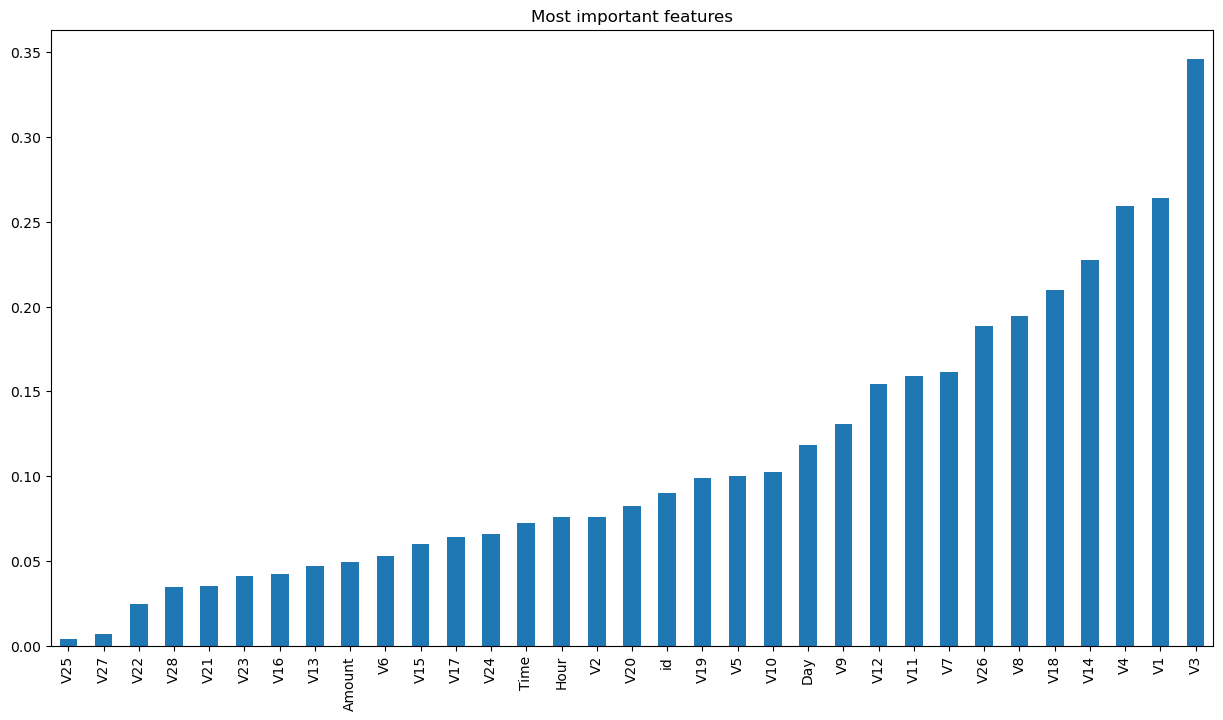

In [10]:
#各特征与目标函数的相关性
plt.figure(figsize=(15,8))
d = new_data.corr()['Class'][:-1].abs().sort_values().plot(kind='bar', title='Most important features')#[:-1]是删除最后的class行，sort_values()按绝对值排列
plt.show()

In [11]:
###4.特征筛选，通过RFE：选择一个初始模型在整个数据集上训练，然后删除权重绝对值最低的特征，重复
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
Selected_features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']
X = new_data[Selected_features]
y = new_data['Class']
# 建立逻辑回归模型用于特征选择
model = LogisticRegression()
# 通过RFE筛选8个相关性最高的特征
rfe = RFE(estimator=model, n_features_to_select=8) 
rfe = rfe.fit(X, y)
# 打印特征
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['V1', 'V3', 'V4', 'V7', 'V8', 'V9', 'V18', 'V26']


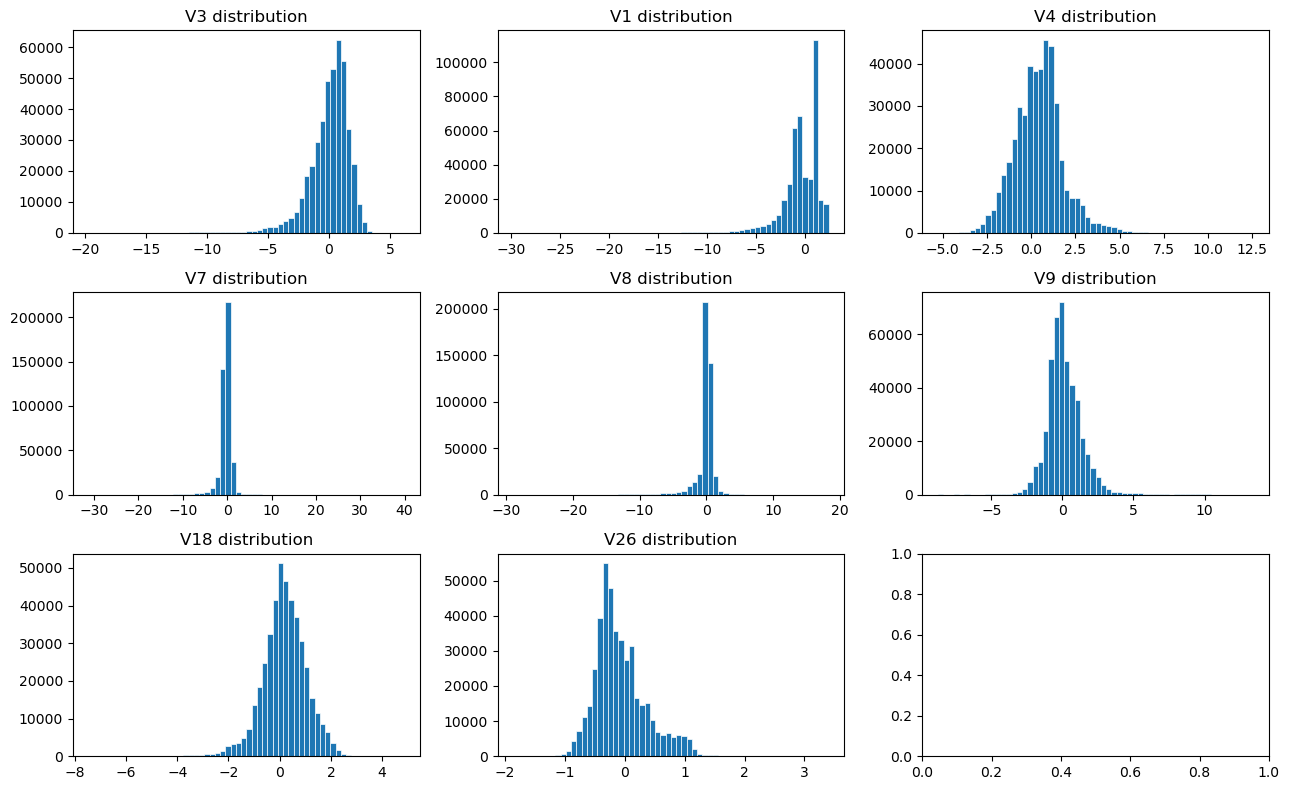

In [13]:
#用直方图表示各特征值的分布情况：横坐标表示特征的取值范围，纵坐标表示对应取值范围内样本的数量
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))

axes[0,0].hist(new_data['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V3 distribution");

axes[0,1].hist(new_data['V1'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V1 distribution");

axes[0,2].hist(new_data['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V4 distribution");

axes[1,0].hist(new_data['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V7 distribution");

axes[1,1].hist(new_data['V8'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V8 distribution");

axes[1,2].hist(new_data['V9'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V9 distribution");

axes[2,0].hist(new_data['V18'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V18 distribution");

axes[2,1].hist(new_data['V26'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V26 distribution");

plt.tight_layout()

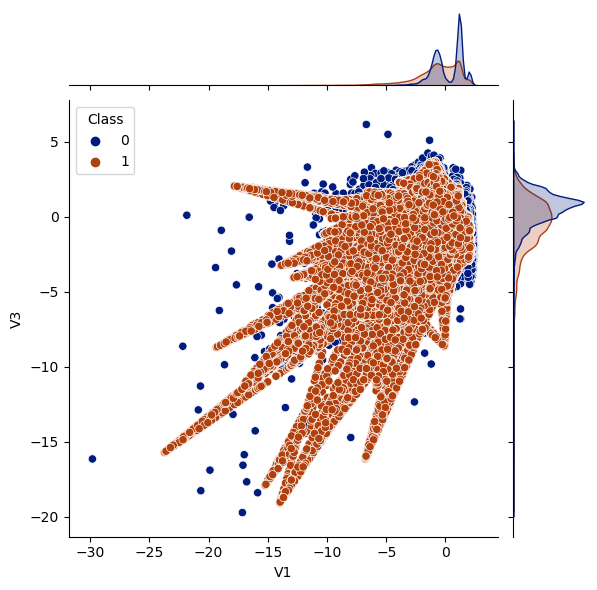

In [12]:
sns.jointplot(x='V1', y='V3',hue='Class', data=new_data, palette = 'dark')

In [13]:
new_data.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

In [15]:
#将训练集中的目标特征单独列成y
y = new_data['Class']
#从训练集 new_data 中去除目标变量，得到包含特征的数据集 X
X = new_data.drop('Class', axis=1)
sc = StandardScaler()#初始化一个标准化器(标准正态)
X = pd.DataFrame(sc.fit_transform(X.values), columns=X.columns, index=X.index)#使用标准化器 sc 对特征数据集 X 进行标准化处理。
test = pd.DataFrame(sc.transform(test.values), columns=test.columns, index=test.index)#使用标准化器 sc 对特征数据集 X 进行标准化处理。
new_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Day,Hour,Class
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,...,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,1,1.0,0
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,...,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,1,1.0,0
2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,...,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,1,1.0,0
3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,...,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,1,1.0,0
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,...,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,1,1.0,0


In [25]:
#xgboost
from xgboost import XGBClassifier
xgb_params = {'n_estimators'     : 2000,#要训练的树的数量
              'min_child_weight' : 96,#叶子节点上的最小权重。
              'max_depth'        : 7,#树的最大深度
              'learning_rate'    : 0.18,#每个树的权重更新的步长
              'subsample'        : 0.95,#用于训练每棵树的样本的子采样比例
              'colsample_bytree' : 0.95,#每棵树的特征子采样比例
              'reg_lambda'       : 1.50,#L2正则化的权重
              'reg_alpha'        : 1.50,#L1正则化的权重
              'gamma'            : 1.50,#裂节点时的最小损失减少
              'max_bin'          : 512,#连续特征的最大分箱数
              'random_state'     : 42,#随机种子，用于控制模型的随机性
              'objective'        : 'binary:logistic',#为二元分类问题的逻辑回归损失函数
              'tree_method'      : 'hist',#用于构建树的方法：直方图加速方法
              'eval_metric'      : 'auc'#评估指标为'AUC'
             }

xgb_scores = []
xgb_recall_scores=[]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train , y_valid = y.iloc[train_idx] , y.iloc[valid_idx]
    
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_train, y_train,verbose=0)
    
    y_pred = xgb_model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  y_pred)
    recall=recall_score(y_valid,  y_pred > 0.5)
    xgb_scores.append(auc)
    print(f"\nFold: {fold+1}, AUC score: {auc:.10f},Recall score:{recall:.10f}\n")
print("Mean AUC :", np.mean(xgb_scores))



Fold: 1, AUC score: 0.9998783020,Recall score:0.9998399341


Fold: 2, AUC score: 0.9998807914,Recall score:0.9998170676


Fold: 3, AUC score: 0.9998368557,Recall score:0.9999085338


Fold: 4, AUC score: 0.9998495324,Recall score:0.9998170676


Fold: 5, AUC score: 0.9998908092,Recall score:0.9997713345

Mean AUC : 0.9998672581352862


In [21]:
#lightgbm
from lightgbm import LGBMClassifier
lgbm_params = {'n_estimators': 100,
                 'num_rounds': 275,
                 'learning_rate': 0.1,
                 'num_leaves': 200,
                 'max_depth': 19,
                 'min_data_in_leaf': 45,
                 'lambda_l1': 0.01,
                 'lambda_l2': 0.9,
                 'min_gain_to_split': 1.42,
                 'bagging_fraction': 0.45,
                 'feature_fraction': 0.3,
                 'reg_alpha': 0.0,
                 'verbose': -1}

lgbm_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)#将数据集划分为 5 个部分进行交叉验证，shuffle对不平衡数据进行洗牌，random_state随机数种子
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):#enumerate() 函数遍历了每个交叉验证的折叠开，_idx 包含了索引
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]#iloc根据索引从完整的特征数据中提取出当前折叠的训练集和验证集。
    y_train , y_valid = y.iloc[train_idx] , y.iloc[valid_idx]#根据索引从完整的目标数据中提取出当前折叠的训练集和验证集。
    
    lgbm_model = LGBMClassifier(**lgbm_params)#初始化一个 LightGBM 分类器模型，并使用之前定义的超参数。
    lgbm_model.fit(X_train, y_train,verbose=0)#用训练集拟合模型，verbose=0 表示不输出训练过程中的信息
    
    y_pred = lgbm_model.predict_proba(X_valid)[:, 1]#对验证集进行预测，返回概率预测结果。
    auc = roc_auc_score(y_valid,  y_pred)#计算验证集上的 AUC（Area Under the ROC Curve）作为性能评价指标。
    lgbm_scores.append(auc)#将当前折叠的 AUC 分数添加到列表 lgbm_scores 中。
    print(115*'-')
    print(f"\nFold: {fold+1}, AUC score: {auc:.2f}\n")
    print(115*'-')
print("Mean AUC :", np.mean(lgbm_scores))

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_gain_to_split is set=1.42, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.42
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] lambda_l2 is set=0.9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9
[LightGBM] [Warning] num_iterations is set=275, num_rounds=275 will be ignored. Current value: num_iterations=275
-------------------------------------------------------------------------------------------------------------------

Fold: 1, AUC score: 1.00

-------------------------------------------

In [ ]:
#SVM
from sklearn import svm
svm_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train , y_valid = y.iloc[train_idx] , y.iloc[valid_idx]
    
    svm_model = svm.SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_model.fit(X_train, y_train)
    
    y_pred = svm_model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  y_pred)
    svm_scores.append(auc)
    print(f"\nFold: {fold+1}, AUC score: {auc:.2f}\n")
print("Mean AUC :", np.mean(svm_scores))

In [16]:
#逻辑回归
from sklearn.linear_model import LogisticRegression
LogisticRegression_scores = []
LogisticRegression_recall_scores=[]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train , y_valid = y.iloc[train_idx] , y.iloc[valid_idx]
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  y_pred)
    recall=recall_score(y_valid,  y_pred > 0.5)
    LogisticRegression_scores.append(auc)
    print(f"\nFold: {fold+1}, AUC score: {auc:.10f}, Recall: {recall:.10f}\n")
print("Mean AUC :", np.mean(LogisticRegression_scores))



Fold: 1, AUC score: 0.8686657037, Recall: 0.7230632031


Fold: 2, AUC score: 0.8680313920, Recall: 0.7182383609


Fold: 3, AUC score: 0.8685101247, Recall: 0.7190158237


Fold: 4, AUC score: 0.8713321400, Recall: 0.7237034666


Fold: 5, AUC score: 0.8696446334, Recall: 0.7214854111

Mean AUC : 0.8692367987593524


In [19]:
#CART
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train , y_valid = y.iloc[train_idx] , y.iloc[valid_idx]
    
    DT = DecisionTreeClassifier()
    DT.fit(X_train, y_train)
    y_pred = DT.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  y_pred)
    DecisionTreeClassifier_scores.append(auc)
    print(f"\nFold: {fold+1}, AUC score: {auc:.2f}\n")
print("Mean AUC :", np.mean(DecisionTreeClassifier_scores))


Fold: 1, AUC score: 0.99


Fold: 2, AUC score: 0.99


Fold: 3, AUC score: 0.99


Fold: 4, AUC score: 0.99


Fold: 5, AUC score: 0.99

Mean AUC : 0.9867008140492087


In [20]:

from sklearn.ensemble import AdaBoostClassifier

AdaBoostClassifier_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train , y_valid = y.iloc[train_idx] , y.iloc[valid_idx]
    
    AB = AdaBoostClassifier()
    AB.fit(X_train, y_train)
    y_pred = AB.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  y_pred)
    AdaBoostClassifier_scores.append(auc)
    print(f"\nFold: {fold+1}, AUC score: {auc:.2f}\n")
print("Mean AUC :", np.mean(AdaBoostClassifier_scores))


Fold: 1, AUC score: 0.91


Fold: 2, AUC score: 0.91


Fold: 3, AUC score: 0.91


Fold: 4, AUC score: 0.91


Fold: 5, AUC score: 0.91

Mean AUC : 0.9067438689742999


In [22]:
#随机森林
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train , y_valid = y.iloc[train_idx] , y.iloc[valid_idx]
    
    RFC = RandomForestClassifier()
    RFC.fit(X_train, y_train)
    y_pred = RFC.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid,  y_pred)
    RandomForestClassifier_scores.append(auc)
    print(f"\nFold: {fold+1}, AUC score: {auc:.2f}\n")
print("Mean AUC :", np.mean(RandomForestClassifier_scores))


Fold: 1, AUC score: 1.00


Fold: 2, AUC score: 1.00


Fold: 3, AUC score: 1.00


Fold: 4, AUC score: 1.00


Fold: 5, AUC score: 1.00

Mean AUC : 0.9999986079911377


In [24]:
#创建只包含预测值为1 的置信度的array数组
pred_table = xgb_model.predict_proba(test)[:, 1]
print(pred_table.size)
pred_table

146087


array([1.3945047e-04, 4.3400037e-03, 5.7919686e-05, ..., 1.1114199e-03,
       3.7035377e-05, 3.4275941e-05], dtype=float32)

In [25]:
#把pred_table添加到提交文档中，并赋予表头
sample_sub['Class']=pred_table
sample_sub

,id,Class
0,219129,0.000139
1,219130,0.004340
2,219131,0.000058
3,219132,0.001037
4,219133,0.000321
...,...,...
146082,365211,0.002794
146083,365212,0.001042
146084,365213,0.001111
146085,365214,0.000037


In [44]:
#生成文档
sample_sub.to_csv('运行结果.csv',index=False)